<font size="6"> **Model Building: Random Forest** </font>

In [1]:
%%capture
%run 00_mlmod_load_data.ipynb

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 8)
sns.set_context("talk")
pd.set_option('precision', 4)

In [3]:
RND_SEED = 123
KFOLDS = 3
pd.set_option('precision', 4)


In [4]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Overwrite persisted versions of sampled data
X_train_smp = pd.read_csv(OUTPATH + 'x_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = pd.read_csv(OUTPATH + 'y_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = y_train_smp[target_col]

# Decision Tree

In [6]:
select_sum_cols = ['mean_test_w_accuracy', 'std_test_w_accuracy', 'rank_test_w_accuracy',
                   'mean_test_accuracy', 'mean_test_up_accuracy','mean_test_down_accuracy', 'mean_test_neg_root_mean_squared_error']

## Hyperparamenter Tunning

In [7]:
hpgrid_dtr = {'ccp_alpha': [0., 1e-6, 1e-5, 1e-4]}

In [8]:
dtr_tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)
dtr = DecisionTreeRegressor(criterion='mse', min_samples_leaf=500, random_state=RND_SEED)

In [9]:
dtr_cv = GridSearchCV(dtr, hpgrid_dtr, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=dtr_tscv_smp, return_train_score=True)
res_dtr_cv = dtr_cv.fit(X_train_smp, y_train_smp)

## CV Grid Search Analysis

In [10]:
dtr_params_df = pd.DataFrame(res_dtr_cv.cv_results_['params'])
dtr_metrics_df = pd.DataFrame(res_dtr_cv.cv_results_)[select_sum_cols]
dtr_sum_df = dtr_params_df.join(dtr_metrics_df)
dtr_sum_df.sort_values(by='rank_test_w_accuracy').head(20)

,ccp_alpha,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
1,1.0000e-06,0.4776,0.0234,1,0.5560,0.4918,0.6285,-0.0300
0,0.0000e+00,0.4744,0.0199,2,0.5548,0.4989,0.6178,-0.0301
2,1.0000e-05,0.4260,0.0544,3,0.5261,0.6171,0.4383,-0.0281
3,1.0000e-04,0.3828,0.0159,4,0.5534,1.0000,0.0000,-0.0285


# Basic Random Forest: Number of Trees estimation

## Hyperparamenter Tunning

In [11]:
brf_tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)
brf = RandomForestRegressor(criterion='mse',
                           max_samples= 0.75, max_features='auto', min_samples_leaf=500,
                            bootstrap=True, oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)

In [12]:
hpgrid_brf = {'n_estimators': [100, 200, 500, 1000]}

In [13]:
brf_cv = GridSearchCV(brf, hpgrid_brf, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=brf_tscv_smp, return_train_score=True)
res_brf_cv = brf_cv.fit(X_train_smp, y_train_smp)

## CV Grid Search Analysis

In [14]:
brf_params_df = pd.DataFrame(res_brf_cv.cv_results_['params'])
brf_metrics_df = pd.DataFrame(res_brf_cv.cv_results_)[select_sum_cols]
brf_sum_df = dtr_params_df.join(brf_metrics_df)
brf_sum_df.sort_values(by='rank_test_w_accuracy')

,ccp_alpha,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
0,0.0000e+00,0.4575,0.0574,1,0.5398,0.5156,0.5717,-0.0282
2,1.0000e-05,0.4529,0.0609,2,0.5387,0.5379,0.5426,-0.0282
1,1.0000e-06,0.4526,0.0614,3,0.5388,0.5406,0.5395,-0.0282
3,1.0000e-04,0.4525,0.0616,4,0.5382,0.5375,0.5418,-0.0282


# Random Forest Weekly Sampling

## Hyperparamenter Tunning

In [15]:
hpgrid_rf_smp = {'max_samples': [0.5, 0.75],
            'max_features': [0.25, 0.5, 0.75],
            'min_samples_leaf': [250, 500, 1000, 2500]}

In [16]:
rf_tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)
rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)

In [17]:
rf_cv = GridSearchCV(rf, hpgrid_rf_smp, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=rf_tscv_smp, return_train_score=True)
res_rf_cv = rf_cv.fit(X_train_smp, y_train_smp)

## CV Grid Search Analysis

In [18]:
rf_params_df = pd.DataFrame(res_rf_cv.cv_results_['params'])
rf_metrics_df = pd.DataFrame(res_rf_cv.cv_results_)[select_sum_cols]
rf_sum_df = rf_params_df.join(rf_metrics_df)
rf_sum_df.sort_values(by='rank_test_w_accuracy').head(10)

,max_features,max_samples,min_samples_leaf,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
20,0.75,0.75,250,0.4661,0.0654,1,0.5641,0.6186,0.4967,-0.0282
16,0.75,0.50,250,0.4657,0.0673,2,0.5554,0.5739,0.5317,-0.0281
8,0.50,0.50,250,0.4555,0.0603,3,0.5528,0.5987,0.4906,-0.0281
12,0.50,0.75,250,0.4552,0.0587,4,0.5549,0.6138,0.4804,-0.0281
17,0.75,0.50,500,0.4525,0.0484,5,0.5363,0.5160,0.5558,-0.0281
21,0.75,0.75,500,0.4521,0.0584,6,0.5395,0.5420,0.5339,-0.0281
13,0.50,0.75,500,0.4430,0.0438,7,0.5443,0.6020,0.4595,-0.0281
22,0.75,0.75,1000,0.4406,0.0477,8,0.5383,0.5829,0.4845,-0.0282
9,0.50,0.50,500,0.4320,0.0353,9,0.5269,0.5511,0.4870,-0.0281
4,0.25,0.75,250,0.4310,0.0412,10,0.5470,0.6805,0.3638,-0.0281


In [19]:
champ_rf_idx = 17
champ_rf_hparms = res_rf_cv.cv_results_['params'][champ_rf_idx]
champ_rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)
champ_rf.set_params(**champ_rf_hparms)
champ_rf.fit(X_train_smp, y_train_smp)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.75, max_leaf_nodes=None,
                      max_samples=0.5, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=500,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=123, verbose=0, warm_start=False)

In [20]:
select_cvdet_cols = ['split0_test_w_accuracy','split1_test_w_accuracy', 'split2_test_w_accuracy', 'mean_test_w_accuracy', 'std_test_w_accuracy', 'rank_test_w_accuracy',
                    'mean_test_accuracy', 'mean_test_neg_root_mean_squared_error']

In [21]:
rf_metrics_cvdet =  pd.DataFrame(res_rf_cv.cv_results_)[select_cvdet_cols]
rf_metrics_cvdet = rf_metrics_cvdet.join(rf_params_df)
rf_metrics_cvdet.head(2)

,split0_test_w_accuracy,split1_test_w_accuracy,split2_test_w_accuracy,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_neg_root_mean_squared_error,max_features,max_samples,min_samples_leaf
0,0.4081,0.3843,0.4756,0.4227,0.0387,15,0.5432,-0.028,0.25,0.5,250
1,0.4038,0.3907,0.4642,0.4196,0.0320,16,0.5460,-0.028,0.25,0.5,500


In [22]:
rf_metrics_cvdet_top = rf_metrics_cvdet.sort_values(by='rank_test_w_accuracy').head(10)
hparams_tb = rf_metrics_cvdet_top.pivot_table(index='rank_test_w_accuracy', values=['max_features', 'max_samples', 'min_samples_leaf']).T

In [23]:
champ_rf_score = rf_metrics_cvdet.loc[champ_rf_idx,'mean_test_w_accuracy']
champ_rf_rank = rf_metrics_cvdet.loc[champ_rf_idx, 'rank_test_w_accuracy']
top_rf_score = rf_metrics_cvdet.loc[rf_metrics_cvdet['rank_test_w_accuracy']==1, 'mean_test_w_accuracy'].iloc[0]
champ_rf_score, champ_rf_rank, top_rf_score

(0.4525333333218307, 5, 0.4661047165514071)

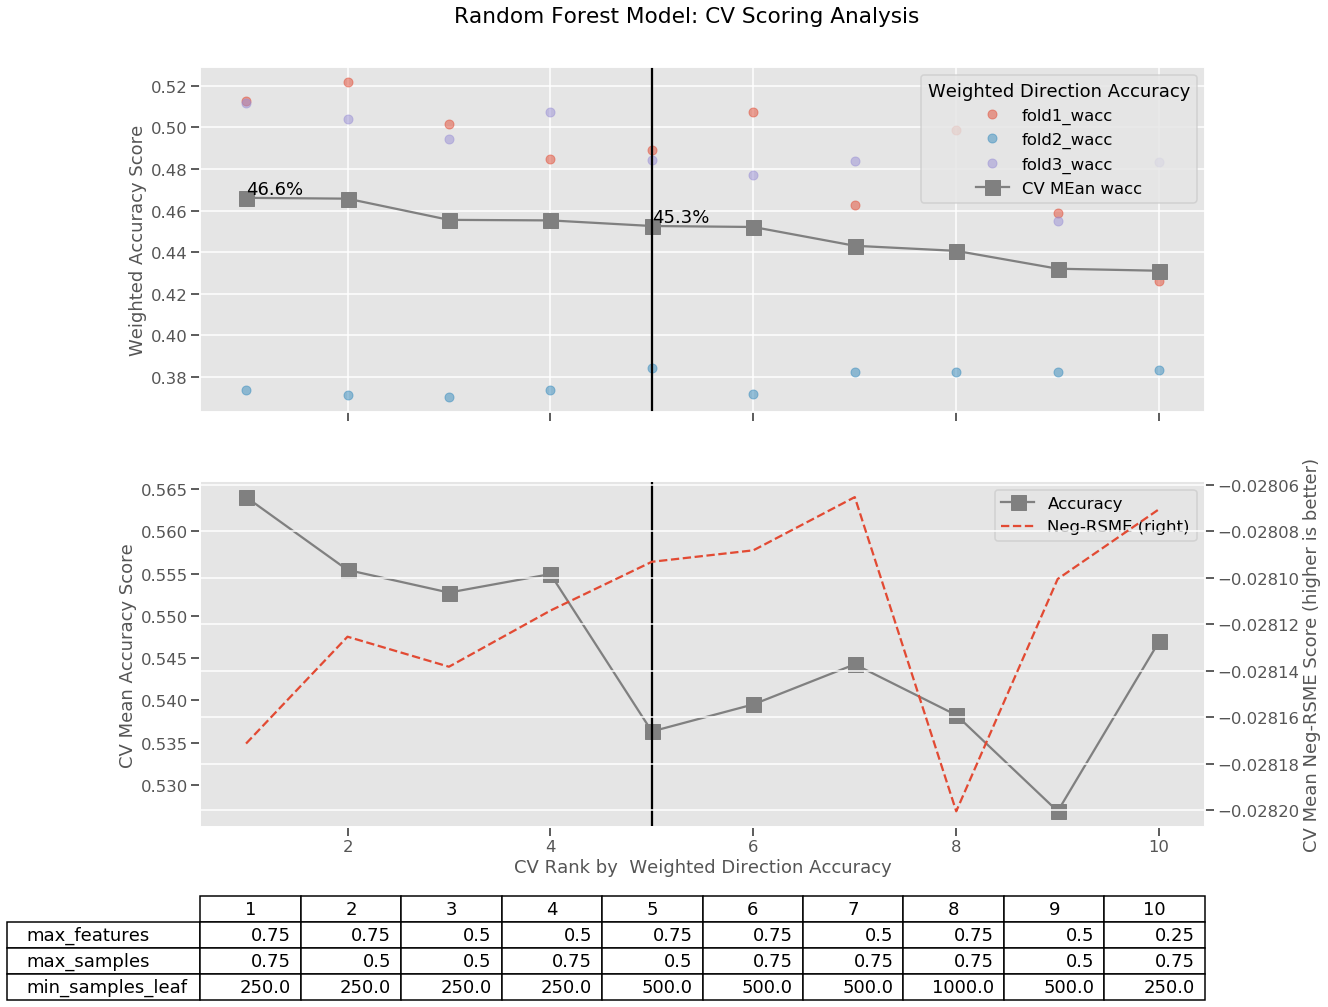

In [24]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(18,12))

plt.suptitle("Random Forest Model: CV Scoring Analysis", y=0.95)
ax = axs[0]
rf_metrics_cvdet_top.plot(ax=ax, x='rank_test_w_accuracy', y=['split0_test_w_accuracy','split1_test_w_accuracy', 'split2_test_w_accuracy'],
                        style='o', alpha=0.5, label=['fold1_wacc', 'fold2_wacc', 'fold3_wacc'])
rf_metrics_cvdet_top.plot(ax=ax, x='rank_test_w_accuracy', y='mean_test_w_accuracy',
                        marker='s', markersize=15, color='grey', label='CV MEan wacc')
ax.legend(title="Weighted Direction Accuracy")
ax.set_ylabel('Weighted Accuracy Score')
ax.text(1, top_rf_score, f'{top_rf_score:.1%}', va='bottom', ha='left')
ax.text(champ_rf_rank, champ_rf_score, f'{champ_rf_score:.1%}', va='bottom', ha='left')

ax = axs[1]
rf_metrics_cvdet_top.plot(ax=ax, x='rank_test_w_accuracy', y='mean_test_accuracy',
                         label='Accuracy',color='grey',
                        marker='s', markersize=15)
plt.ylabel('CV Mean Accuracy Score')

rf_metrics_cvdet_top.plot(ax=ax, x='rank_test_w_accuracy', y='mean_test_neg_root_mean_squared_error',
                         secondary_y=True,
                         label='Neg-RSME',
                         linestyle='--')

plt.ylabel('CV Mean Neg-RSME Score (higher is better)')
ax.set_xlabel('CV Rank by  Weighted Direction Accuracy')

rf_metrics_cvdet_top_tb = ax.table(cellText=hparams_tb.astype(str).values,
                      rowLabels=hparams_tb.index.tolist(),
                      colLabels=hparams_tb.columns.tolist(),
                      loc='bottom',bbox=[0., -.5, 1., .3])#[left, bottom, width , height]

rf_metrics_cvdet_top_tb.auto_set_font_size(True)

for ax in axs:
    ax.axvline(x=champ_rf_rank, color='black')
plt.subplots_adjust(bottom=0.)


plt.show()


There are several models that may be nice to select, model ranked 6 (max_features=0.75, max_samples=0.75, min_samles_leaf=1000) is a good choice:
* Hyperparameters discussion:
    * `max_features=0.75` means that 75% features will be considered at each split (on each tree). In general, this is quite high, however, there are many OHE variables and each skelarn tree is binary, therefore, the general rule of sqrt(n_features) should be checked.
    * `max_samples=0.5` implies that each tree is built on a bootstrapped sample of 50% size. This parameter was recenty added (in sklearn 0.22)
    * Both `max_features` and `max_samples` controls regularization: the lower they are, the less correlated that each decision tree will be; in general, this allows to avoid overfitting, however, also makes individual trees less and less powerfull
    * `min_samples_leaf=500` indirectly controls tree depth, by not allowing leaves to be too small; a size of 500 means that there is a day size of observations (Stocks). The deeper a tree, the greater chances of overfitting, all in all, if leaves are very small, spurious patterns may be spot
* The top ranked model is slightly less regularized and performance scores are quite similar (regarding selected model), sadly, dispersion on CV scores is quite high.

# Random Forest Full Dataset

## Hyperparameter Tunning

In [25]:
hpgrid_rf_full = {'max_samples': [0.25, 0.5, 0.75],
            'max_features': [0.2, 0.5, 0.75],
            'min_samples_leaf': [500, 1000, 2500]}

In [26]:
rf_full_tscv = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_full)
rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)

In [27]:
rf_full_cv = GridSearchCV(rf, hpgrid_rf_full, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=rf_full_tscv, return_train_score=True)
res_rf_full_cv = rf_full_cv.fit(X_train_full, y_train_full)

## CV Grid Search Analysis

In [28]:
rf_full_params_df = pd.DataFrame(res_rf_full_cv.cv_results_['params'])
rf_full_metrics_df = pd.DataFrame(res_rf_full_cv.cv_results_)[select_sum_cols]
rf_full_sum_df = rf_full_params_df.join(rf_full_metrics_df)
rf_full_sum_df.sort_values(by='rank_test_w_accuracy').head(10)

,max_features,max_samples,min_samples_leaf,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
18,0.75,0.25,500,0.4697,0.0430,1,0.5522,0.5283,0.5837,-0.0286
22,0.75,0.50,1000,0.4651,0.0367,2,0.5426,0.4906,0.6107,-0.0286
13,0.50,0.50,1000,0.4560,0.0434,3,0.5414,0.5303,0.5552,-0.0284
19,0.75,0.25,1000,0.4548,0.0412,4,0.5201,0.4155,0.6595,-0.0285
26,0.75,0.75,2500,0.4537,0.0461,5,0.5194,0.4171,0.6519,-0.0285
0,0.20,0.25,500,0.4532,0.0478,6,0.5461,0.5680,0.5160,-0.0283
25,0.75,0.75,1000,0.4532,0.0273,7,0.5294,0.4650,0.6087,-0.0287
3,0.20,0.50,500,0.4528,0.0407,8,0.5293,0.4762,0.5988,-0.0287
7,0.20,0.75,1000,0.4520,0.0432,9,0.5423,0.5524,0.5281,-0.0284
23,0.75,0.50,2500,0.4519,0.0348,10,0.5221,0.4395,0.6308,-0.0283


In [29]:
rf_full_metrics_cvdet =  pd.DataFrame(res_rf_full_cv.cv_results_)[select_cvdet_cols]
rf_full_metrics_cvdet = rf_full_metrics_cvdet.join(rf_full_params_df)
rf_full_metrics_cvdet.head(2)

,split0_test_w_accuracy,split1_test_w_accuracy,split2_test_w_accuracy,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_neg_root_mean_squared_error,max_features,max_samples,min_samples_leaf
0,0.5032,0.3888,0.4677,0.4532,0.0478,6,0.5461,-0.0283,0.2,0.25,500
1,0.4123,0.3837,0.4900,0.4287,0.0449,23,0.5492,-0.0282,0.2,0.25,1000


# Random Forest Non-Overlapping Sample: Voting Ensemble

## Hyperparameter Tunning

In [30]:
rf_tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)
rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)

In [31]:
rf_nov_cv = GridSearchCV(rf, hpgrid_rf_smp, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=rf_tscv_smp, return_train_score=True)
res_rf_nov_cv = rf_nov_cv.fit(X_train_smp[features_nov], y_train_smp)

## CV Grid Search Analysis

In [32]:
rf_nov_params_df = pd.DataFrame(res_rf_nov_cv.cv_results_['params'])
rf_nov_metrics_df = pd.DataFrame(res_rf_nov_cv.cv_results_)[select_sum_cols]
rf_nov_sum_df = rf_params_df.join(rf_nov_metrics_df)
rf_nov_sum_df.sort_values(by='rank_test_w_accuracy').head(10)

,max_features,max_samples,min_samples_leaf,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
20,0.75,0.75,250,0.4691,0.0697,1,0.5631,0.6022,0.5156,-0.0282
16,0.75,0.50,250,0.4644,0.0656,2,0.5520,0.5622,0.5416,-0.0282
21,0.75,0.75,500,0.4578,0.0623,3,0.5398,0.5223,0.5617,-0.0281
8,0.50,0.50,250,0.4569,0.0617,4,0.5565,0.6153,0.4783,-0.0281
12,0.50,0.75,250,0.4505,0.0596,5,0.5510,0.6146,0.4664,-0.0281
13,0.50,0.75,500,0.4467,0.0537,6,0.5485,0.6131,0.4570,-0.0281
17,0.75,0.50,500,0.4446,0.0472,7,0.5248,0.4896,0.5658,-0.0282
4,0.25,0.75,250,0.4442,0.0514,8,0.5542,0.6603,0.4074,-0.0281
0,0.25,0.50,250,0.4325,0.0520,9,0.5531,0.7162,0.3322,-0.0281
9,0.50,0.50,500,0.4315,0.0433,10,0.5344,0.6028,0.4340,-0.0281


In [33]:
rf_nov_metrics_cvdet =  pd.DataFrame(res_rf_nov_cv.cv_results_)[select_cvdet_cols]
rf_nov_metrics_cvdet = rf_nov_metrics_cvdet.join(rf_nov_params_df)
rf_nov_metrics_cvdet.head(2)

,split0_test_w_accuracy,split1_test_w_accuracy,split2_test_w_accuracy,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_neg_root_mean_squared_error,max_features,max_samples,min_samples_leaf
0,0.4193,0.3765,0.5018,0.4325,0.0520,9,0.5531,-0.0281,0.25,0.5,250
1,0.4042,0.3798,0.4702,0.4181,0.0382,15,0.5417,-0.0281,0.25,0.5,500


## Benchmarking

In [34]:
rf_params = list(hpgrid_rf_smp.keys())
rf_metrics = ['std_test_w_accuracy', 'mean_test_w_accuracy', 'rank_test_w_accuracy']

rf_sum_join_df = rf_sum_df[rf_params + rf_metrics].set_index('rank_test_w_accuracy').join(
    rf_nov_sum_df[rf_params +  rf_metrics].set_index('rank_test_w_accuracy'),
        lsuffix='_smp', rsuffix='_nov').join(
    rf_full_sum_df[rf_params +  rf_metrics].set_index('rank_test_w_accuracy').add_suffix("_full"))

rf_sum_join_top_df = rf_sum_join_df.sort_values(by='rank_test_w_accuracy').head(10)
rf_sum_join_top_df

,max_samples_smp,max_features_smp,min_samples_leaf_smp,std_test_w_accuracy_smp,mean_test_w_accuracy_smp,max_samples_nov,max_features_nov,min_samples_leaf_nov,std_test_w_accuracy_nov,mean_test_w_accuracy_nov,max_samples_full,max_features_full,min_samples_leaf_full,std_test_w_accuracy_full,mean_test_w_accuracy_full
rank_test_w_accuracy,,,,,,,,,,,,,,,
1,0.75,0.75,250,0.0654,0.4661,0.75,0.75,250,0.0697,0.4691,0.25,0.75,500,0.0430,0.4697
2,0.50,0.75,250,0.0673,0.4657,0.50,0.75,250,0.0656,0.4644,0.50,0.75,1000,0.0367,0.4651
3,0.50,0.50,250,0.0603,0.4555,0.75,0.75,500,0.0623,0.4578,0.50,0.50,1000,0.0434,0.4560
4,0.75,0.50,250,0.0587,0.4552,0.50,0.50,250,0.0617,0.4569,0.25,0.75,1000,0.0412,0.4548
5,0.50,0.75,500,0.0484,0.4525,0.75,0.50,250,0.0596,0.4505,0.75,0.75,2500,0.0461,0.4537
6,0.75,0.75,500,0.0584,0.4521,0.75,0.50,500,0.0537,0.4467,0.25,0.20,500,0.0478,0.4532
7,0.75,0.50,500,0.0438,0.4430,0.50,0.75,500,0.0472,0.4446,0.75,0.75,1000,0.0273,0.4532
8,0.75,0.75,1000,0.0477,0.4406,0.75,0.25,250,0.0514,0.4442,0.50,0.20,500,0.0407,0.4528
9,0.50,0.50,500,0.0353,0.4320,0.50,0.25,250,0.0520,0.4325,0.75,0.20,1000,0.0432,0.4520


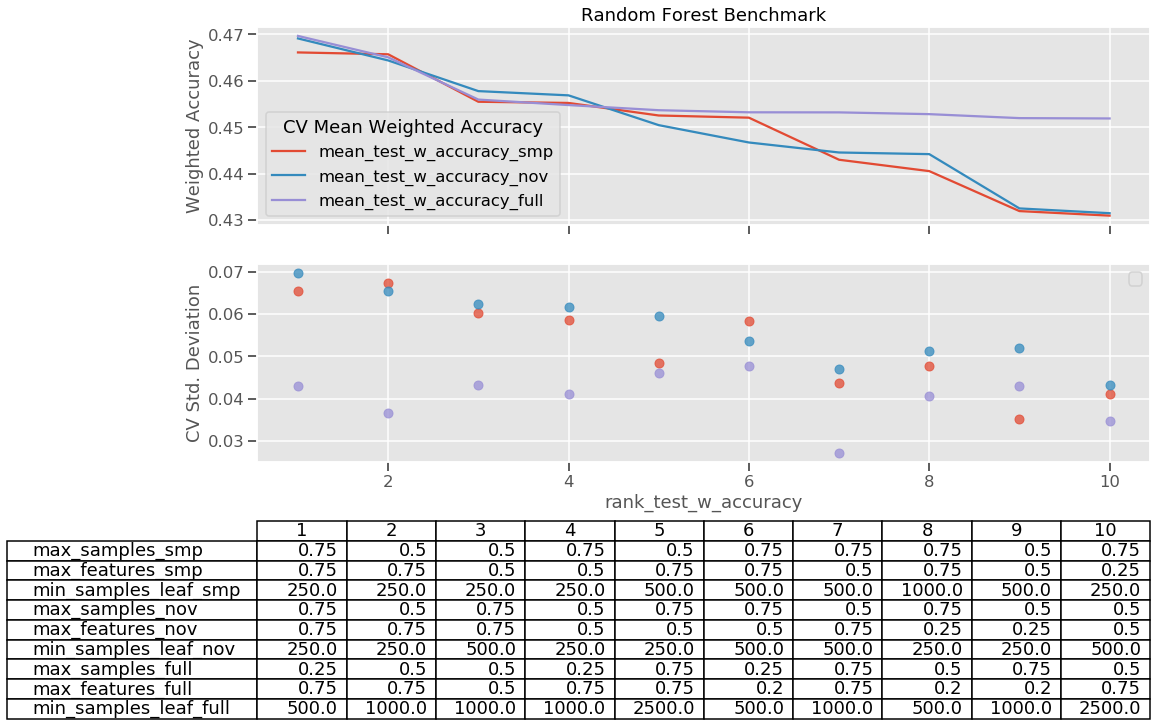

In [35]:
fig, axs = plt.subplots(2,1, sharex=True)

ax =  axs[0]
rf_sum_join_top_df.filter(regex='^mean_').plot(ax=ax, label=['sample', 'sample no weekday (nov)', 'full'])
ax.legend(title='CV Mean Weighted Accuracy')
ax.set_ylabel('Weighted Accuracy')
ax.set_title("Random Forest Benchmark")

ax =  axs[1]
ax = rf_sum_join_top_df.filter(regex='^std_').plot(ax=ax, style='o', alpha=0.75)
ax.legend("")
ax.set_ylabel('CV Std. Deviation')


rf_params_cols = [x for x in rf_sum_join_top_df.columns if x[:x.rfind("_")] in rf_params]
colors = [[ax.get_lines()[i].get_color()]*len(rf_params) for i in range(0,3)]

rf_benchmark_tb = plt.table(cellText=rf_sum_join_top_df[rf_params_cols].T.astype(str).values,
                      rowLabels=rf_params_cols,
                      colLabels=rf_sum_join_top_df.index,
                      loc='bottom',bbox=[0., -1.3, 1., 1.])#[left, bottom, width , height]

rf_benchmark_tb.auto_set_font_size(True)


plt.show()

## Experimental Ensemble

In [36]:
hparams_rf_nov = {'max_samples': 0.5,
            'max_features': 0.75,
            'min_samples_leaf': 500}

In [37]:
rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED, **hparams_rf_nov)

In [38]:
rf_nov = mle_utils.NoOverlapVoterRegressor(base_estimator=rf, n_skip_samples=4)
rf_nov.fit(X_train_full[features_nov], y_train_full)

NoOverlapVoterRegressor(base_estimator=RandomForestRegressor(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             criterion='mse',
                                                             max_depth=None,
                                                             max_features=0.75,
                                                             max_leaf_nodes=None,
                                                             max_samples=0.5,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=500,
                                                             min_samples_split=2,
                                                             min_weight_fraction_leaf=0.0,
                      

# Write Reports

In [39]:
benchmark_path = OUTPATH + "benchmark" + "/"

rf_sum_df.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "rf_smp_summary.csv")
rf_full_sum_df.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "rf_full_summary.csv")
rf_nov_sum_df.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "rf_nov_summary.csv")

rf_sum_join_df.to_csv(benchmark_path + "rf_benchmark.csv")
rf_metrics_cvdet.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "rf_smp_cvdet.csv")
rf_full_metrics_cvdet.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "rf_full_cvdet.csv")
rf_nov_metrics_cvdet.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "rf_nov_cvdet.csv")